# Predicting the Newsletter Subscription status of Minecraft Players
!!! <br>
A data science project submitted in partial fulfillment of the Requirements for the DSCI 100 Introduction to Data Science Course at the University of British Columbia <br>
Jun 23, 2025

## Introduction

!!! Re-phrase

A research group in Computer Science at UBC, The Pacific Laboratory for Artificial Intelligence (PLAI), led by Frank Wood, is collecting data on players of MineCraft. They have set up a MineCraft server, and players' information and actions are recorded.

Player types are by experience: Veteran, Pro, Regular, Amateur

In order to target their recruitment efforts, they would like to know 
**What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?**



This project will explore some aspects of the above question, specifically:
compare the predictive power of age, total hours, total number of sessions and max duration for whether a player ia subsribed to the newsleetter.

How do characteristics like age, gender etc. differ between various player types (exprience levels).


Specifically, it will look at 


!!! In your project, you will select one of these broad questions and use it to formulate a specific question using some of the variables in the dataset.  Your project should answer your specific question. 




## Methods & Results
1. First explore the player characteristics
2. Explore the behavior
2. Based on initial exploration, select which factors to use in the model for predicting subscription or not
3. Build model, predict
4. Assess prediction

In [1]:
# !!! Be sure to load only the needed ones

library(tidyverse)
library(repr)
library(tidymodels)

# set seed once for reproducibility
set.seed(2473)

# Only display top 6 rows of data frames
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### 1. Read the data

In [15]:
players_data <- read_csv("data/players.csv")
sessions_data <- read_csv("data/sessions.csv")

players_data
sessions_data

# Check for Missing NA values

any(is.na(players_data)) #TRUE - there are two observations without age
any(is.na(sessions_data)) #TRUE - there are two observations without end time

# Since there are only two observations wihtout end time, and two observations without age,
# we will remove them to not cause issues in downstream analyses
sessions_data_NA_omitted <- na.omit(sessions_data)
players_data_NA_omitted <- na.omit(players_data)

# check if there are any start and end dates that aren't the same for a single session
sessions_data_sep_date_time <- sessions_data |>
    separate(col = start_time, into = c("start_date", "start_time"), sep = " ") |>
    separate(col = end_time, into = c("end_date", "end_time"), sep = " ")

sessions_data_diff_start_end_date <- sessions_data_sep_date_time |>
    filter(start_date != end_date)

sessions_data_diff_start_end_date

# Yes, there are 92 cases of sessions spanning 2 (or more) days

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


[1] TRUE

[1] TRUE

hashedEmail,start_date,start_time,end_date,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,12/05/2024,23:23,13/05/2024,00:14,1.71556e+12,1.71556e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,29/06/2024,21:26,30/06/2024,00:00,1.71970e+12,1.71971e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,27/07/2024,23:30,28/07/2024,00:23,1.72212e+12,1.72213e+12
⋮,⋮,⋮,⋮,⋮,⋮,⋮
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,03/08/2024,22:33,04/08/2024,00:51,1.72272e+12,1.72273e+12
b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,18/08/2024,21:54,19/08/2024,02:09,1.72402e+12,1.72403e+12
b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,28/08/2024,23:31,29/08/2024,00:15,1.72489e+12,1.72489e+12


Clean up the data:

In [21]:
## Convert categorical variables to factor, esp needed for subscribe, which we are interested in classifying by:
players_data_clean <- players_data_NA_omitted |>
    mutate(subscribe = as_factor(subscribe)) |>
    mutate(experience = as_factor(experience)) |>
    mutate(gender = as_factor(gender)) #|>
    #mutate(subscribe = fct_recode(subscribe, "TRUE" = "subscribed", "FALSE" = "Not subscribed"))   # !!! can't get to work

sessions_data_clean <- sessions_data_NA_omitted |>
    mutate(start_time = as.POSIXct(start_time, format = "%d/%m/%Y %H:%M")) |>
    mutate(end_time = as.POSIXct(end_time, format = "%d/%m/%Y %H:%M")) |>
    select(hashedEmail:end_time) # Since we will not be using the original times

# View clean data and dimensions:
players_data_clean
dim(players_data_clean)

sessions_data_clean
dim(sessions_data)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<fct>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


[1] 194   7

hashedEmail,start_time,end_time
<chr>,<dttm>,<dttm>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00
⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-28 15:36:00,2024-07-28 15:57:00
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-25 06:15:00,2024-07-25 06:22:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-20 02:26:00,2024-05-20 02:45:00


[1] 1535    5

!!! Next, scatterplot of Age vs Total time played with points colored by subscription status or not to see if there are any visible patterns.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


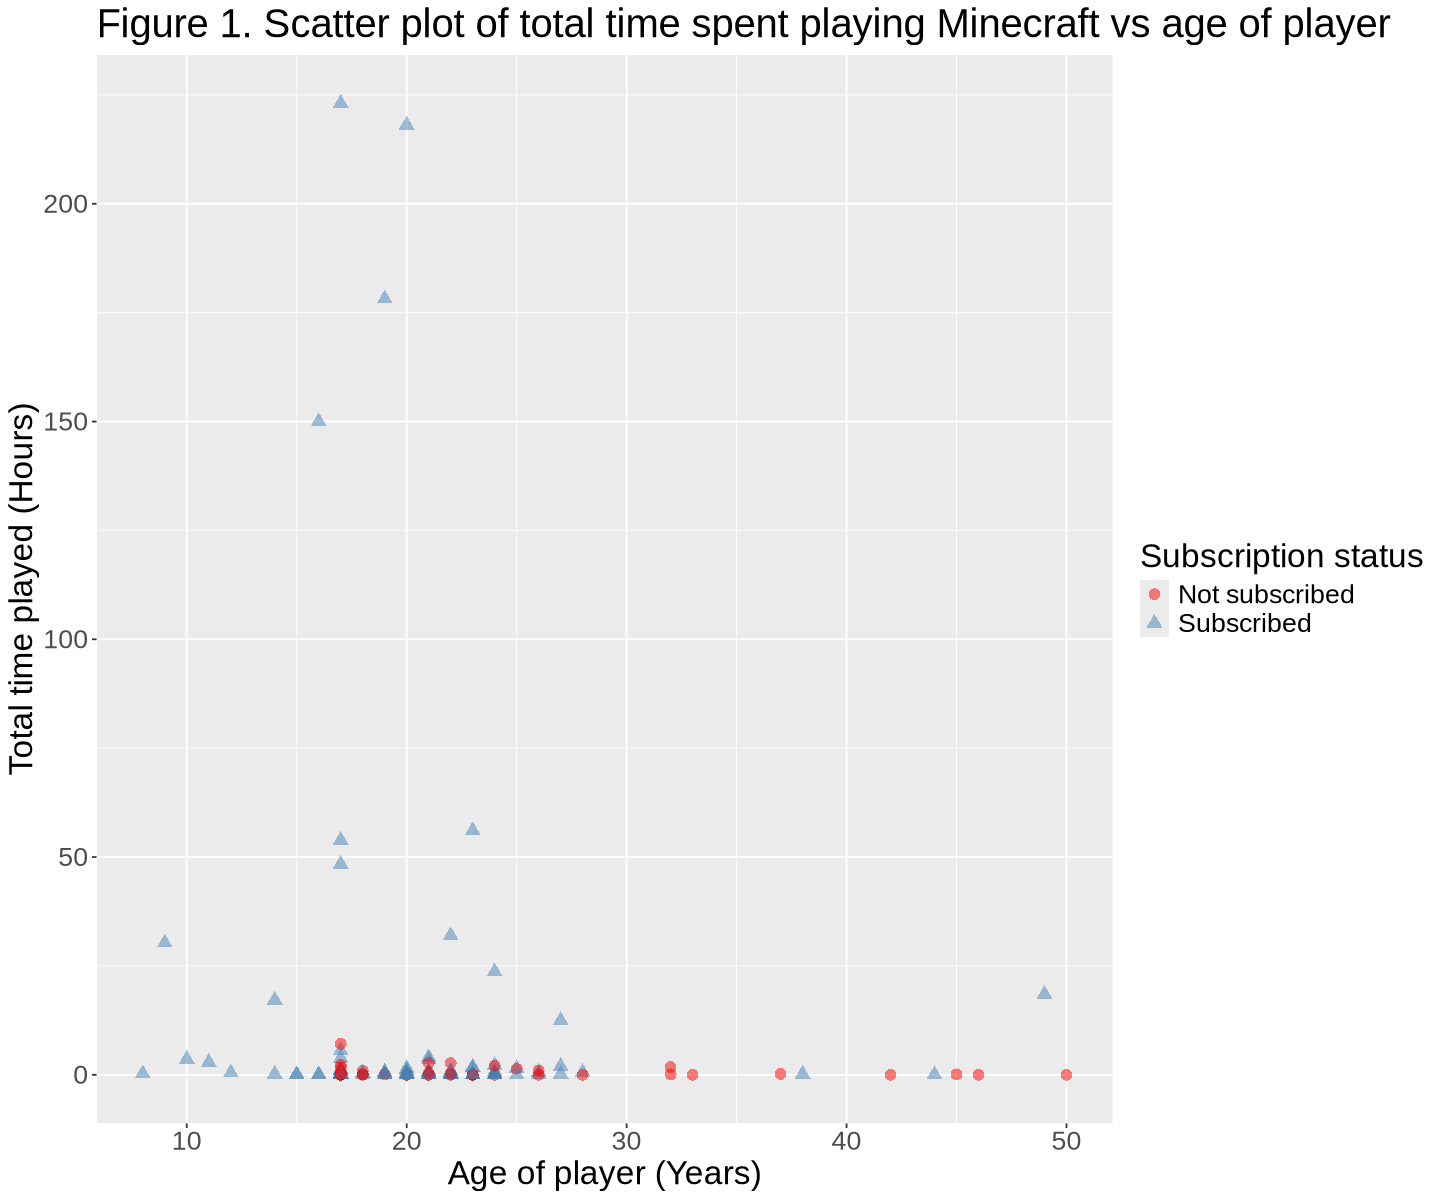

In [17]:
# Scatter plot of played hours, age?

options(repr.plot.width=12, repr.plot.height=10)

players_hours_age_plot <- ggplot(players_data, aes(x = Age,
                                                   y = played_hours,
                                                   color = subscribe,
                                                   shape = subscribe)) +
    geom_point(size = 3, alpha = 0.5) +
    labs(x = "Age of player (Years)",
        y = "Total time played (Hours)", 
        color = "Subscription status",
        shape = "Subscription status") +
        theme(text = element_text(size = 20)) +
        ggtitle("Figure 1. Scatter plot of total time spent playing Minecraft vs age of player") +
        scale_color_manual(values = c("FALSE" = "red", "TRUE" = "steelblue"),
                       labels = c("FALSE" = "Not subscribed", "TRUE" = "Subscribed")) +
        scale_shape_manual(values = c("FALSE" = 16, "TRUE" = 17),
                       labels = c("FALSE" = "Not subscribed", "TRUE" = "Subscribed"))


players_hours_age_plot

To investigates differences among player types.
the how gender varies among player types, which are categorical variables, use bar plot:


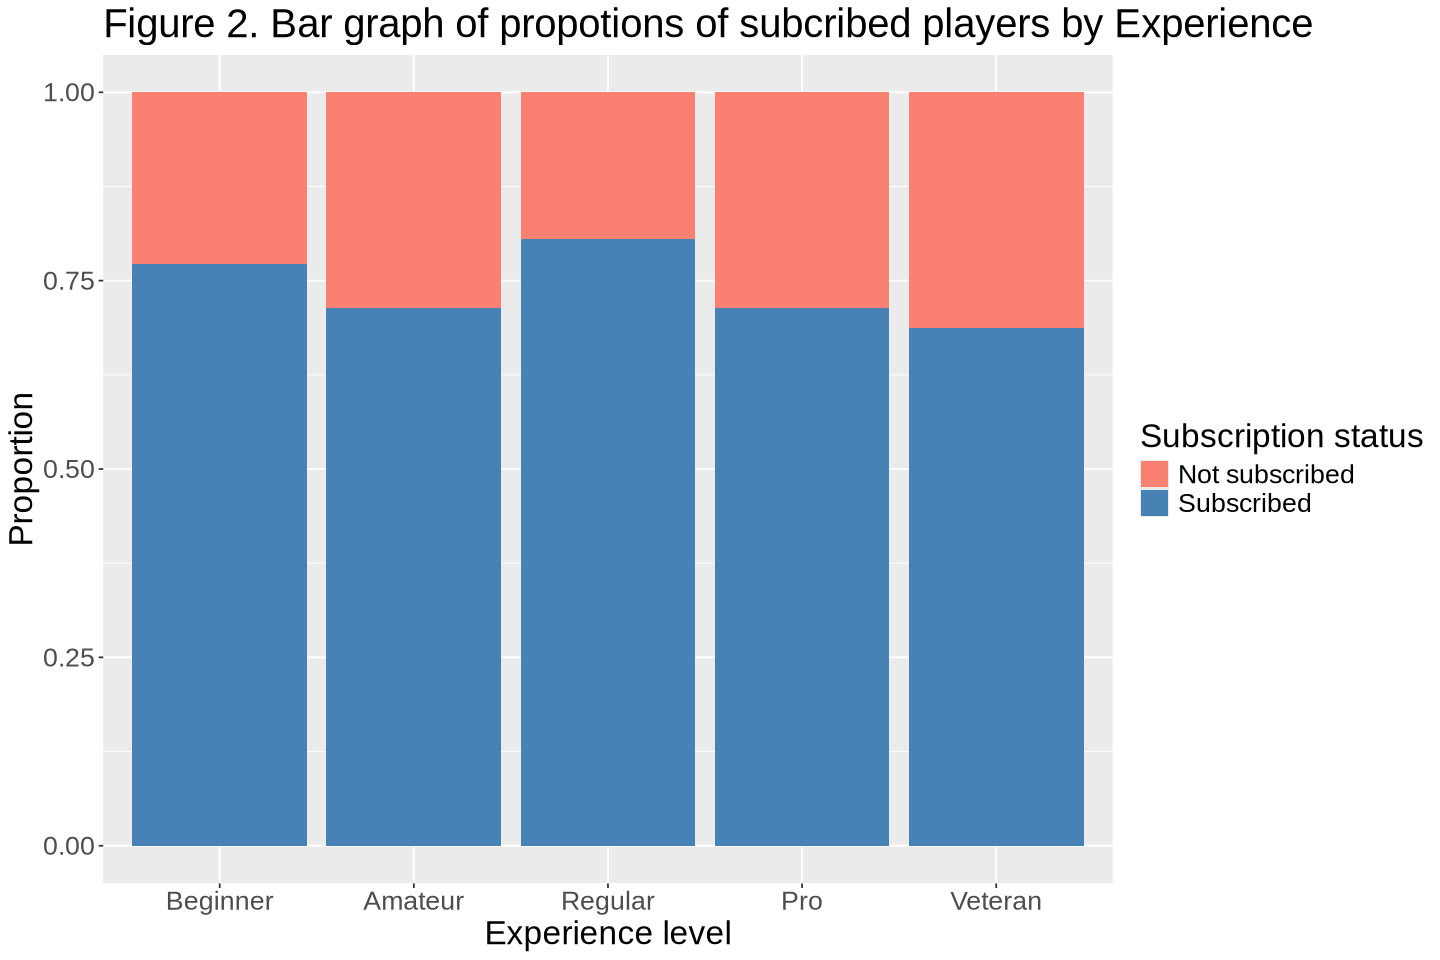

In [9]:
# Plot and subscription status vs experience?
options(repr.plot.width=12, repr.plot.height=8)

# Order from least experienced to most experienced
players_data$experience <- factor(players_data$experience,
                                  levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran"))

experience_plot <- players_data |>
    ggplot(aes(x = experience, fill = subscribe)) +
    geom_bar(position = "fill") +
    labs(x = "Experience level",
        y = "Proportion", 
        fill = "Subscription status") +
        theme(text = element_text(size = 20)) +
        ggtitle("Figure 2. Bar graph of propotions of subcribed players by Experience") +
        scale_fill_manual(values = c("FALSE" = "salmon", "TRUE" = "steelblue"),
                       labels = c("FALSE" = "Not subscribed", "TRUE" = "Subscribed"))

experience_plot

Check if exprience and hours played has a positive relationship as expected:




In [10]:
# Order from least experienced to most experienced
players_data$experience <- factor(players_data$experience,
                                  levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran"))

mean_hours_by_experience <- players_data |>
    group_by(experience) |>
    summarize(mean(played_hours))

mean_hours_by_experience

experience,mean(played_hours)
<fct>,<dbl>
Beginner,1.2485714
Amateur,6.0174603
Regular,18.2083333
Pro,2.6000000
Veteran,0.6479167


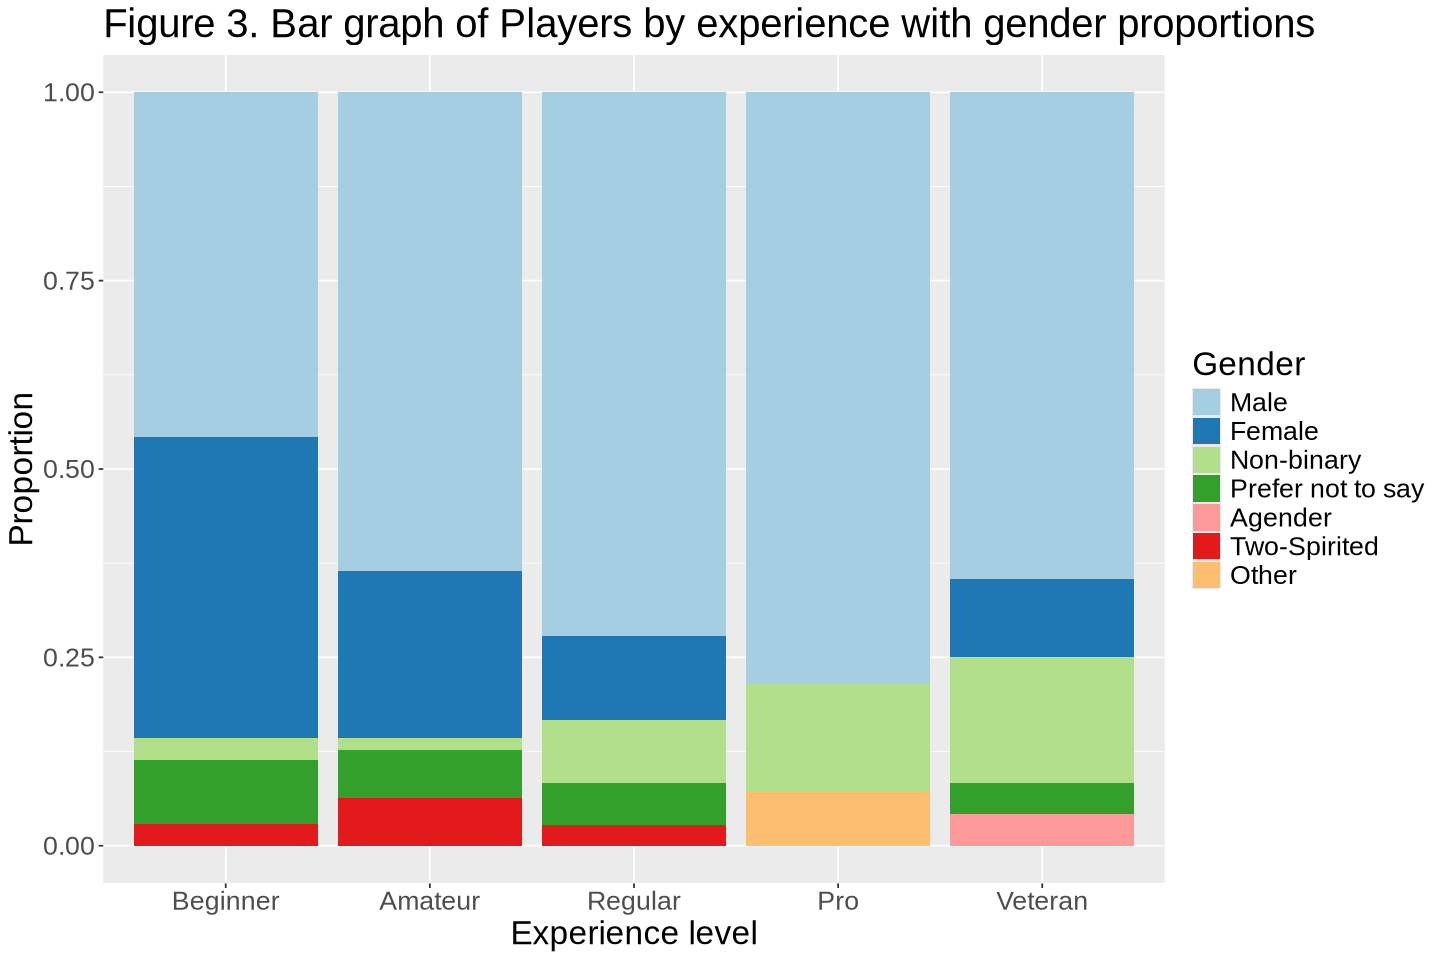

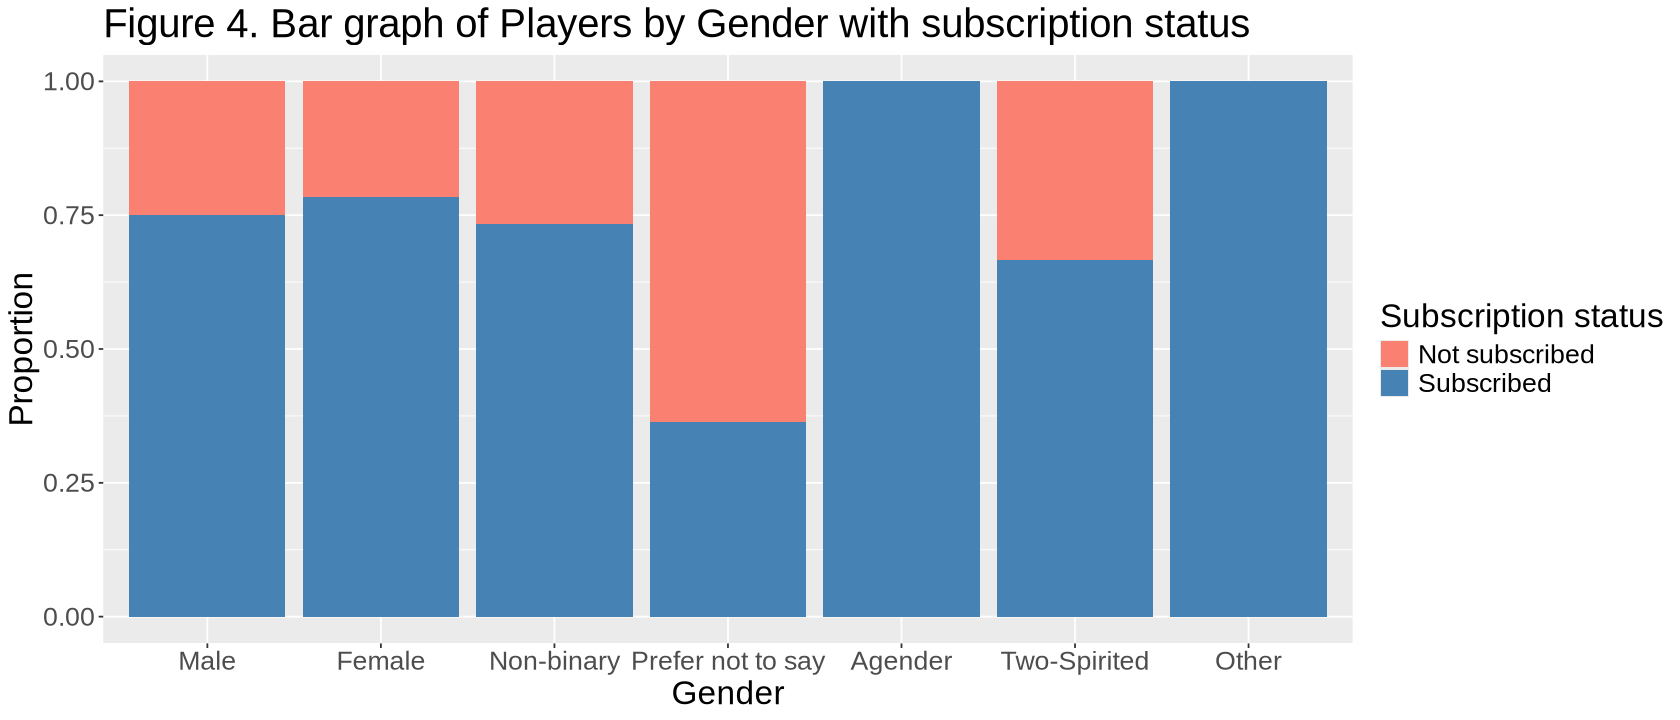

In [73]:
## Let's look at gender:
options(repr.plot.width=12, repr.plot.height=8)

experience_gender_plot <- players_data |>
    ggplot(aes(x = experience, fill = gender)) +
    geom_bar(position = "fill") + #fill/dodge/stack
    labs(x = "Experience level",
        y = "Proportion", 
        fill = "Gender") +
        theme(text = element_text(size = 20)) +
        ggtitle("Figure 3. Bar graph of Players by experience with gender proportions") +
        # scale_fill_manual(values = c("FALSE" = "salmon", "TRUE" = "steelblue"),
        #                labels = c("FALSE" = "Not subscribed", "TRUE" = "Subscribed"))
        scale_fill_brewer(palette = "Paired")

experience_gender_plot


options(repr.plot.width=14, repr.plot.height=6)
gender_subscribe_plot <- players_data |>
    ggplot(aes(x = gender, fill = subscribe)) +
    geom_bar(position = "fill") + #fill/dodge/stack
    labs(x = "Gender",
        y = "Proportion", 
        fill = "Subscription status") +
        theme(text = element_text(size = 20)) +
        ggtitle("Figure 4. Bar graph of Players by Gender with subscription status") +
        scale_fill_manual(values = c("FALSE" = "salmon", "TRUE" = "steelblue"),
                       labels = c("FALSE" = "Not subscribed", "TRUE" = "Subscribed")) #+
        #scale_fill_brewer(palette = "Paired")

gender_subscribe_plot

Next, look at behavior. We will look at two aspects of behavior: duration of session, frequency of session. We first create a summary 

In [40]:
# Calculate duration of each session
sessions_data_clean <- sessions_data_clean |>
    mutate(duration = end_time - start_time)

# Calculate mean and max duration per session and frequency (total number of sessions) for each player
sessions_data_summary <- sessions_data_clean |>
    group_by(hashedEmail) |>
    summarize(mean_duration = mean(duration),
              max_duration = max(duration),
             frequency = n())

# Use left join to merge player info and sessions summary info
# so that all players are kept, including those with no sessions
player_info_sessions_summary <- players_data_clean |>
    left_join(sessions_data_summary, by = "hashedEmail")

# For players with no sessions set mean_duration, max_duration and frequency to 0
player_info_sessions_summary <- player_info_sessions_summary |>
    mutate(mean_duration = replace_na(mean_duration, as.duration(0)),
           max_duration = replace_na(max_duration, as.duration(0)),
           frequency = replace_na(frequency, 0))

player_info_sessions_summary

experience,subscribe,hashedEmail,played_hours,name,gender,Age,mean_duration,max_duration,frequency
<fct>,<fct>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<drtn>,<drtn>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,74.77778 mins,211 mins,27
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,85.00000 mins,160 mins,3
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,5.00000 mins,5 mins,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22,21.00000 mins,21 mins,1
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17,5.00000 mins,5 mins,1
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,29.83333 mins,118 mins,6


Don't know how to automatically pick scale for object of type <difftime>.
Defaulting to continuous.


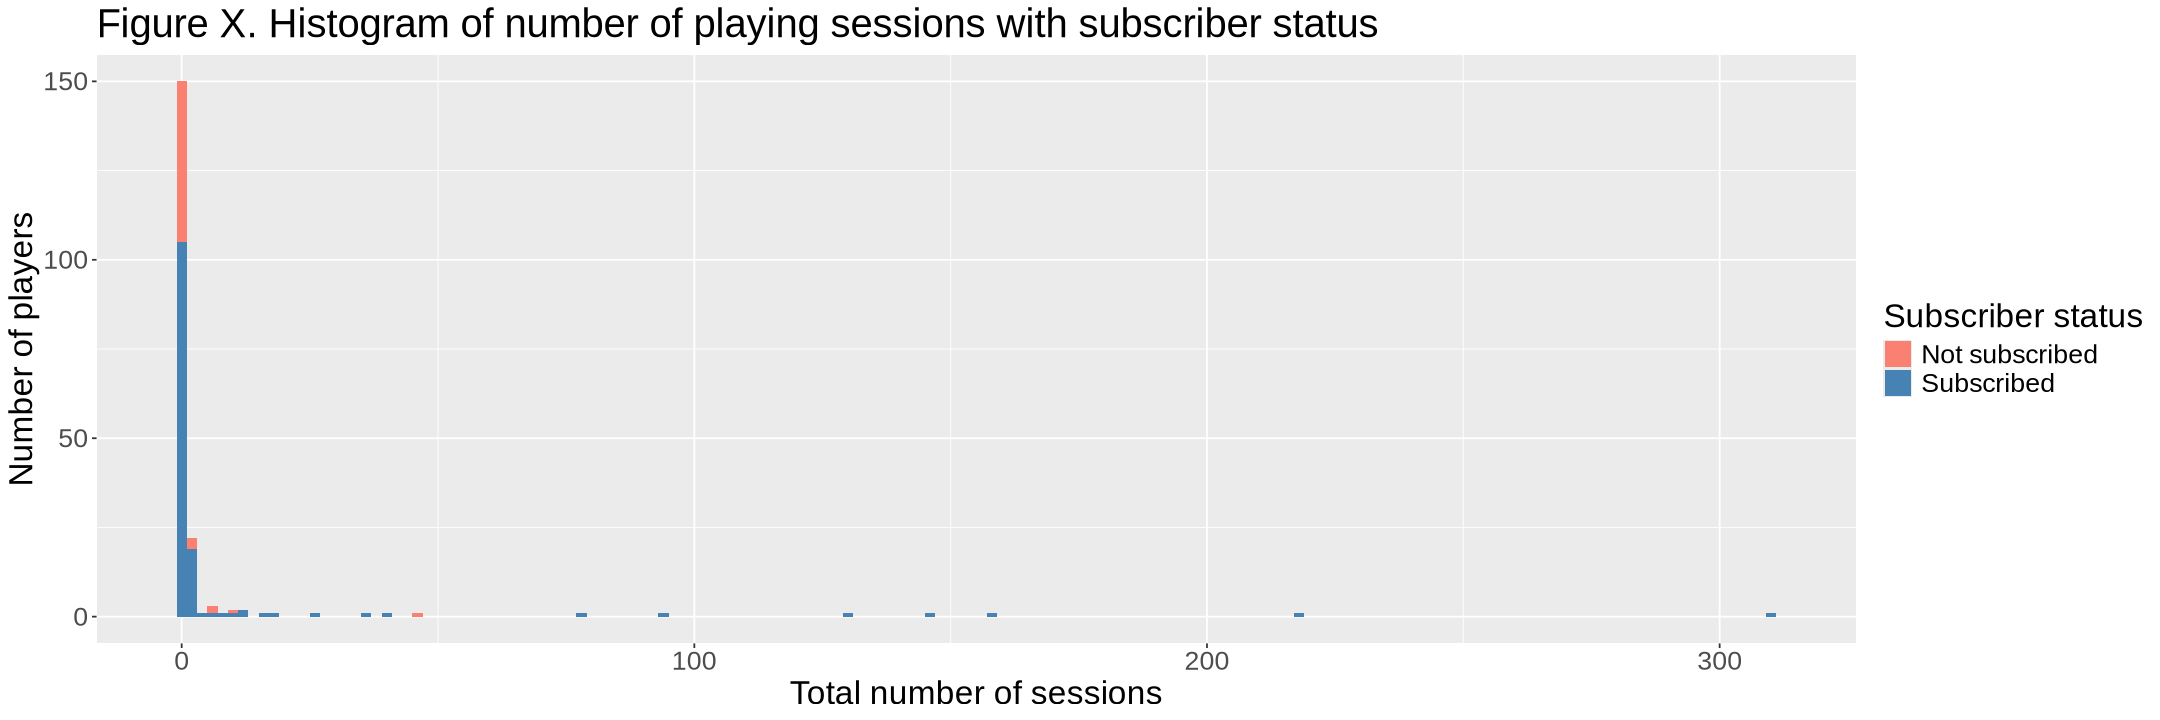

Don't know how to automatically pick scale for object of type <difftime>.
Defaulting to continuous.


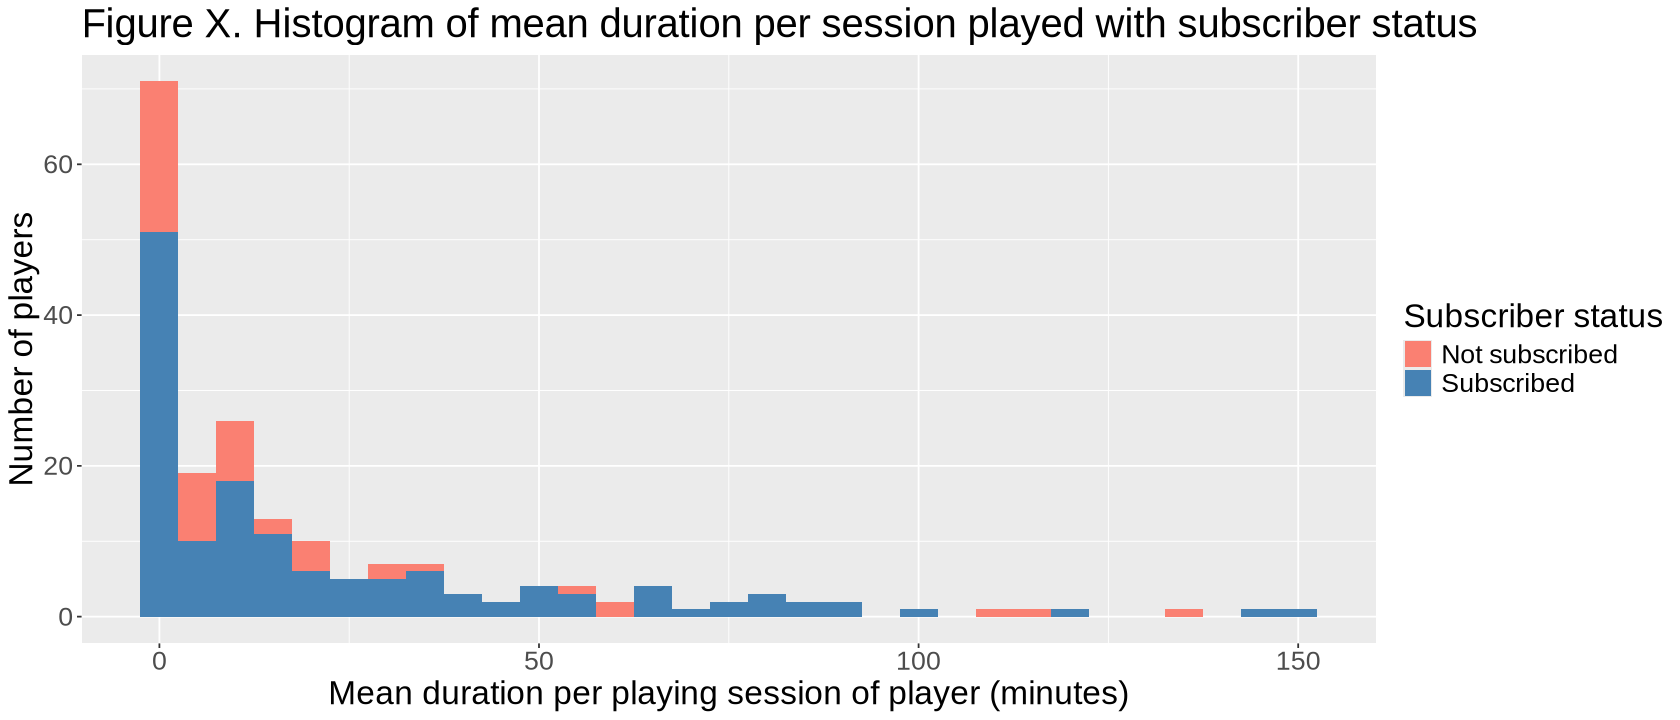

Don't know how to automatically pick scale for object of type <difftime>.
Defaulting to continuous.


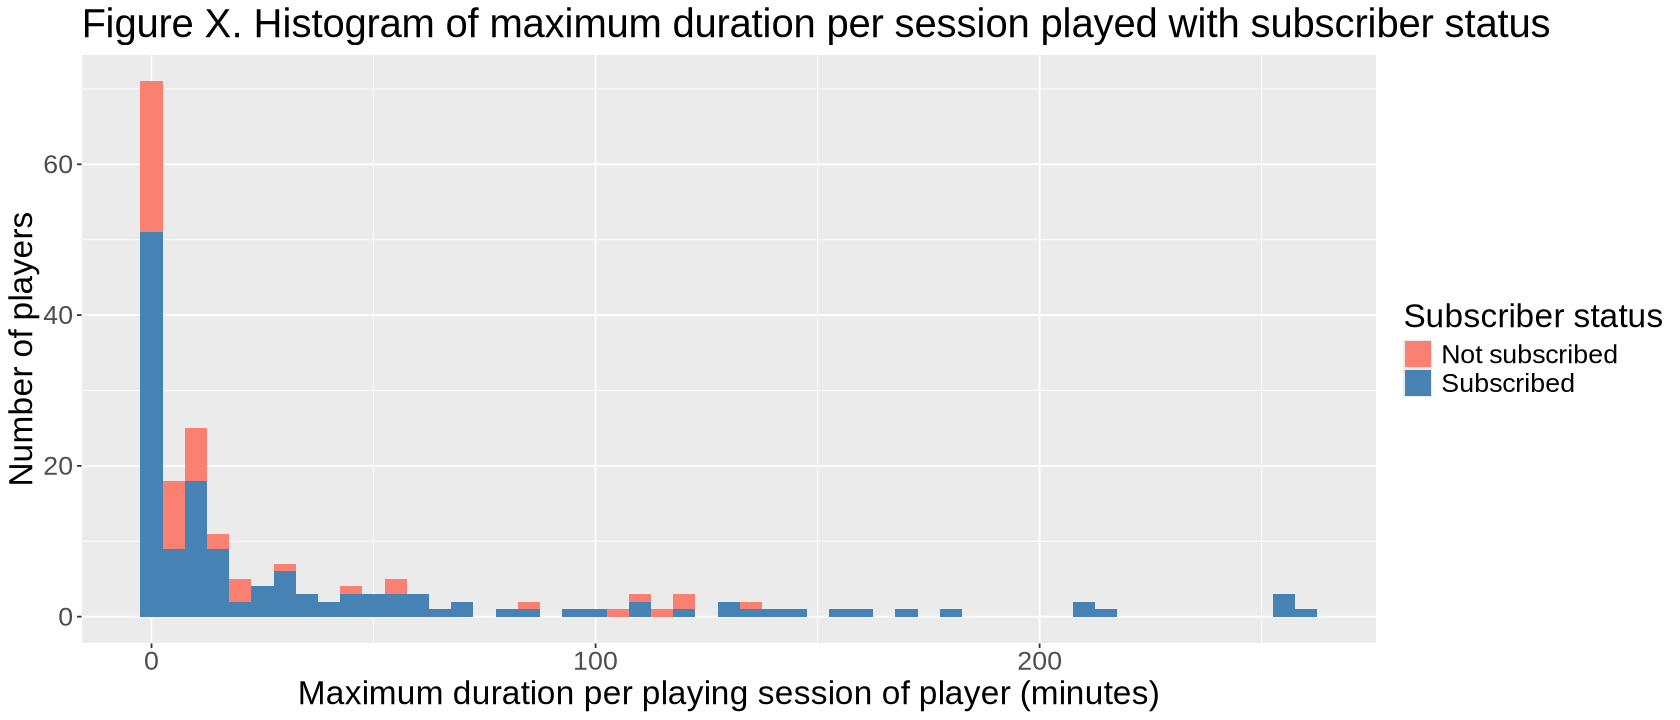

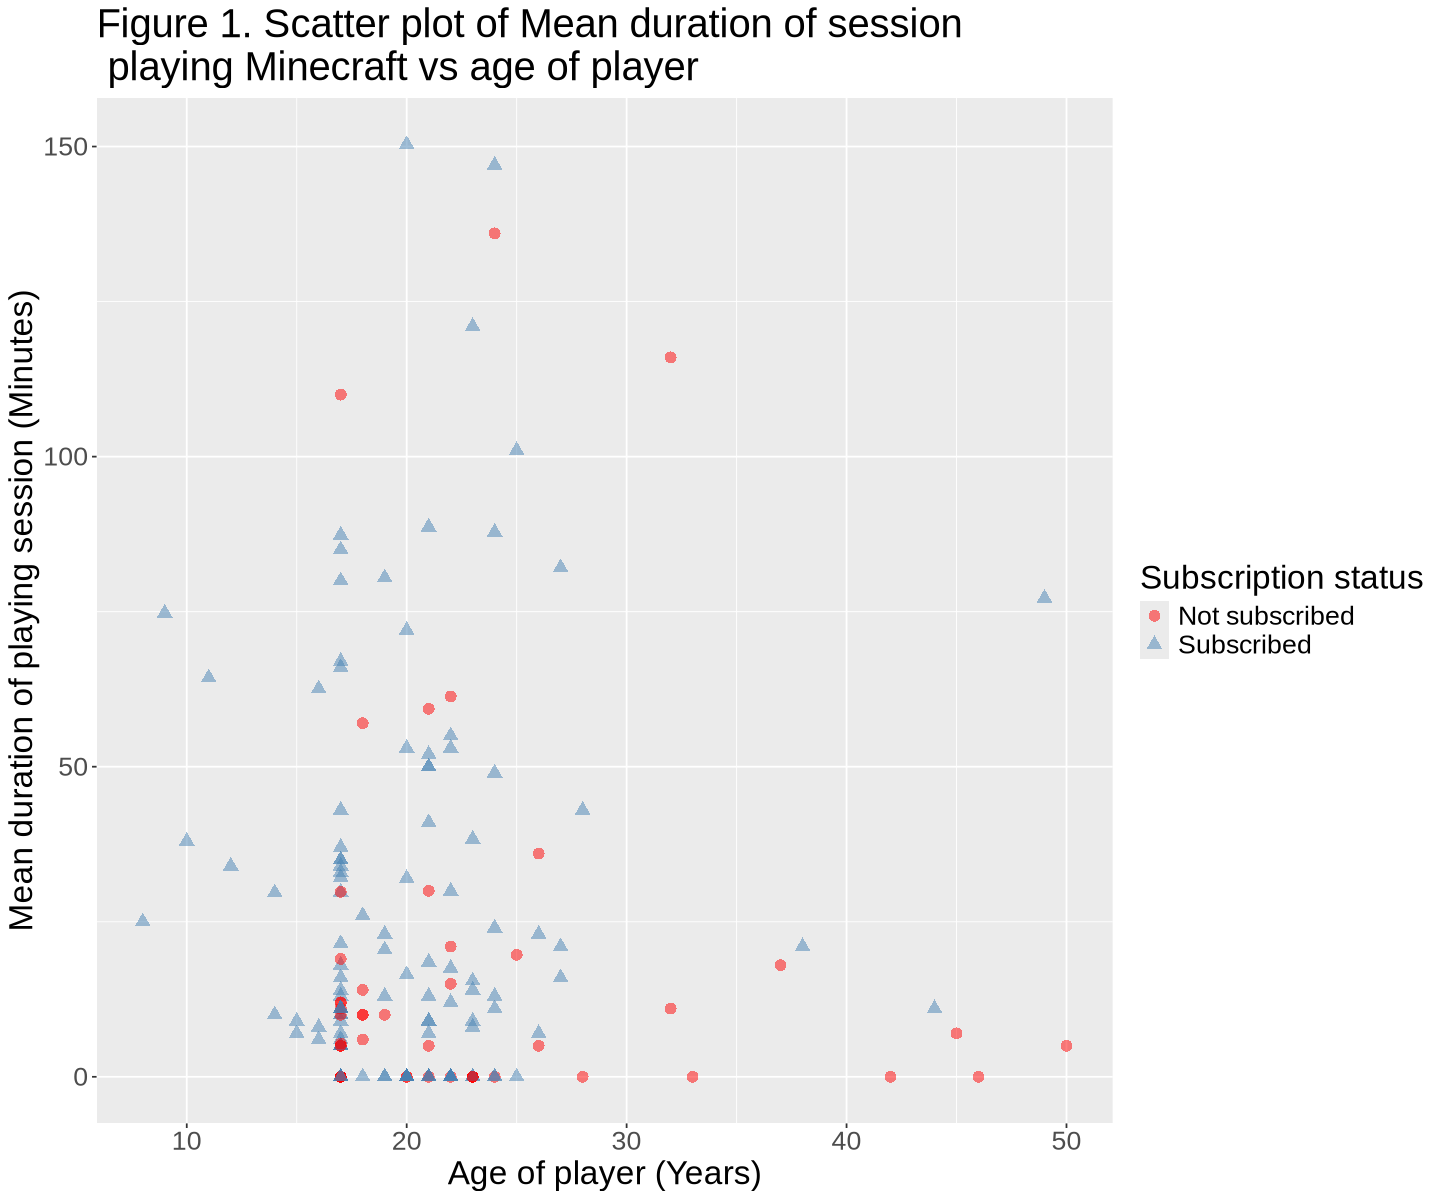

In [42]:
options(repr.plot.width=18, repr.plot.height=6)

selected_binwidth = 5

# Histrogram of frequency
hist_mean_freq_subscribe <- player_info_sessions_summary |>
    ggplot(aes(x = frequency, fill = subscribe)) +
    geom_histogram(binwidth = binwidth) +
    labs(x = "Total number of sessions",
        y = "Number of players",
        fill = "Subscriber status") +
    theme(text = element_text(size = 20)) +
    ggtitle("Figure X. Histogram of number of playing sessions with subscriber status") +
    scale_fill_manual(values = c("FALSE" = "salmon", "TRUE" = "steelblue"),
                       labels = c("FALSE" = "Not subscribed", "TRUE" = "Subscribed"))

hist_mean_freq_subscribe


# Histogram of Mean Duration
options(repr.plot.width=14, repr.plot.height=6)

hist_mean_duration_subscribe <- player_info_sessions_summary |>
    ggplot(aes(x = mean_duration, fill = subscribe)) +
    geom_histogram(binwidth = selected_binwidth) +
    labs(x = "Mean duration per playing session of player (minutes)",
        y = "Number of players",
        fill = "Subscriber status") +
    theme(text = element_text(size = 20)) +
    ggtitle("Figure X. Histogram of mean duration per session played with subscriber status") +
    scale_fill_manual(values = c("FALSE" = "salmon", "TRUE" = "steelblue"),
                       labels = c("FALSE" = "Not subscribed", "TRUE" = "Subscribed"))

hist_mean_duration_subscribe

# Histogram of Max Duration
              
hist_max_duration_subscribe <- player_info_sessions_summary |>
    ggplot(aes(x = max_duration, fill = subscribe)) +
    geom_histogram(binwidth = selected_binwidth) +
    labs(x = "Maximum duration per playing session of player (minutes)",
        y = "Number of players",
        fill = "Subscriber status") +
    theme(text = element_text(size = 20)) +
    ggtitle("Figure X. Histogram of maximum duration per session played with subscriber status") +
    scale_fill_manual(values = c("FALSE" = "salmon", "TRUE" = "steelblue"),
                       labels = c("FALSE" = "Not subscribed", "TRUE" = "Subscribed"))

hist_max_duration_subscribe


# Age and duration


options(repr.plot.width=12, repr.plot.height=10)

players_hours_age_plot <- ggplot(player_info_sessions_summary, aes(x = Age,
                                                   y = mean_duration,
                                                   color = subscribe,
                                                   shape = subscribe)) +
    geom_point(size = 3, alpha = 0.5) +
    labs(x = "Age of player (Years)",
        y = "Mean duration of playing session (Minutes)", 
        color = "Subscription status",
        shape = "Subscription status") +
        theme(text = element_text(size = 20)) +
        ggtitle("Figure 1. Scatter plot of Mean duration of session \n playing Minecraft vs age of player") +
        scale_color_manual(values = c("FALSE" = "red", "TRUE" = "steelblue"),
                       labels = c("FALSE" = "Not subscribed", "TRUE" = "Subscribed")) +
        scale_shape_manual(values = c("FALSE" = 16, "TRUE" = 17),
                       labels = c("FALSE" = "Not subscribed", "TRUE" = "Subscribed"))


players_hours_age_plot

Doesn't appear to be a strong relationship between subscription status and mean duration of session. COuld be more subscribers among those that play short up to 10 min sessions at at time. Then another high proprotion at 100+ minutes average session

Let's try to do a classification with gender and total time spend playing the game as predictors, max session duration, number of playing sessions only

And compared to classificaiton with all predictors, several combinations of the above.

We would exepct the first to be more accurate

In [ ]:
# recipes

# Split 

recipe_age <- recipe(subscribe ~ age,
                   data = sessions_data_behavior_duration) |>
                step_center(all_predictors()) +
                step_scale(all_predictors())

recipe_age <- recipe(subscribe ~ played_hours + age + max_duration + frequency,
                   data = sessions_data_behavior_duration) |>
                step_center(all_predictors()) +
                step_scale(all_predictors())

## Discussion

## References